In [1]:
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import time

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
# Загружаем файл с первым вариантом обработки данных, агрегация по mean.
file_path = 'data_mean_first_var.parquet'
table = pq.read_table(file_path)
df = table.to_pandas()
print(f"Обработка файла завершена.")

Обработка файла завершена.


id                               0
rn                               0
pre_pterm                        0
pre_fterm                        0
pre_till_pclose                  0
pre_loans_credit_limit           0
pre_loans_next_pay_summ          0
pre_loans_outstanding            0
pre_loans_total_overdue          0
pre_loans_max_overdue_sum        0
pre_loans_credit_cost_rate       0
pre_loans5                       0
pre_loans530                     0
pre_loans3060                    0
pre_loans6090                    0
pre_loans90                      0
is_zero_loans5                   0
is_zero_loans530                 0
is_zero_loans3060                0
is_zero_loans6090                0
is_zero_loans90                  0
pre_util                         0
pre_over2limit                   0
pre_maxover2limit                0
is_zero_util                     0
is_zero_over2limit               0
is_zero_maxover2limit            0
enc_paym_3                       0
enc_paym_12         

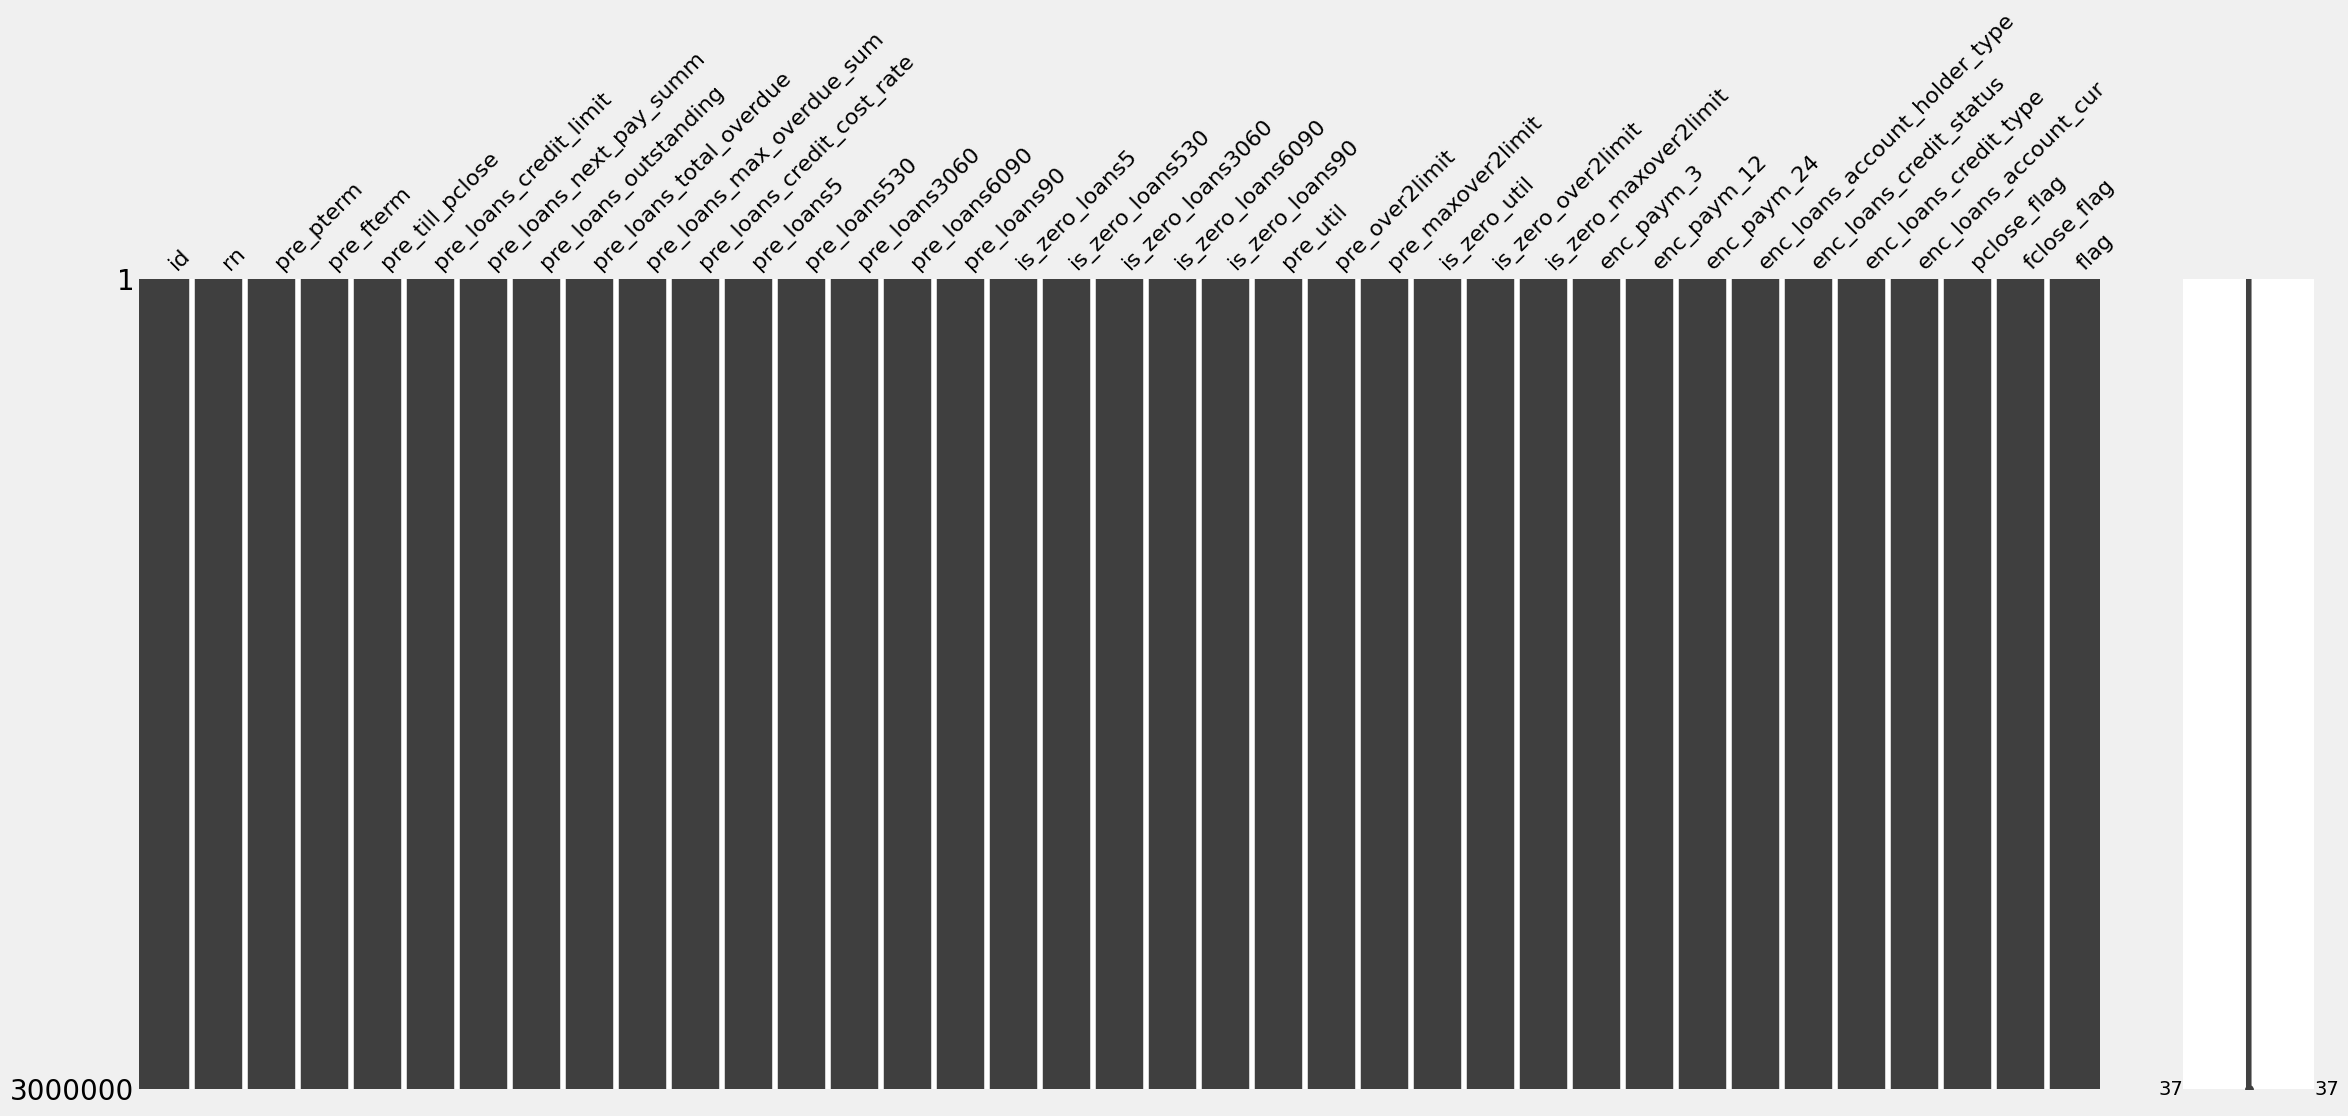

________________________________
Пропусков нет в данных.
________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 37 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             float64
 1   rn                             float64
 2   pre_pterm                      float64
 3   pre_fterm                      float64
 4   pre_till_pclose                float64
 5   pre_loans_credit_limit         float64
 6   pre_loans_next_pay_summ        float64
 7   pre_loans_outstanding          float64
 8   pre_loans_total_overdue        float64
 9   pre_loans_max_overdue_sum      float64
 10  pre_loans_credit_cost_rate     float64
 11  pre_loans5                     float64
 12  pre_loans530                   float64
 13  pre_loans3060                  float64
 14  pre_loans6090                  float64
 15  pre_loans90                    float64
 16  

In [3]:
# Смотрим пропуски

print(df.isna().sum())
print('________________________________')
# Смотрим пропуски на графике
msno.matrix(df)
plt.show()
print('________________________________')
# Пробуем найти даже 1 пропуск, который не видно на графике и можно было бы не заметить при просмотре вывода строки 3-4. 
missing_columns = df.columns[df.isnull().any()]

if missing_columns.empty:
    print("Пропусков нет в данных.")
else:
    print("Пропуски обнаружены в следующих столбцах:")
    for column in missing_columns:
        missing_count = df[column].isnull().sum()
        print(f"{column}: {missing_count} пропусков")
print('________________________________')
# Информация о датафрейме
df.info()
print('________________________________')
# Описание датафрейма
print(df.describe())
print('________________________________')
# Баланс классов целевой переменной
print(df['flag'].value_counts())
print('________________________________')


In [4]:
numeric_columns = df.select_dtypes(include='number')

for column in numeric_columns.columns:
    non_numeric_values = pd.to_numeric(df[column], errors='coerce').isnull()
    if non_numeric_values.any():
        print(f"В колонке {column} содержатся значения, отличные от чисел.")
    else:
        print(f"Все значения численные")


Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные


In [5]:
df.head(30)

,id,rn,pre_pterm,pre_fterm,pre_till_pclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,...,enc_paym_3,enc_paym_12,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,0.0,6.0,8.0,8.0,12.0,10.0,4.0,3.0,0.0,2.0,...,1.0,2.0,4.0,1.0,3.0,4.0,1.0,1.0,1.0,0
1,1.0,8.0,7.0,8.0,11.0,9.0,3.0,3.0,0.0,2.0,...,1.0,2.0,4.0,1.0,3.0,4.0,1.0,1.0,1.0,0
2,2.0,2.0,7.0,6.0,5.0,2.0,2.0,3.0,0.0,2.0,...,1.0,3.0,4.0,1.0,3.0,4.0,1.0,1.0,1.0,0
3,3.0,8.0,8.0,8.0,6.0,10.0,3.0,4.0,0.0,2.0,...,1.0,2.0,3.0,1.0,3.0,4.0,1.0,1.0,1.0,0
4,4.0,1.0,4.0,8.0,1.0,12.0,1.0,3.0,0.0,2.0,...,3.0,3.0,4.0,1.0,2.0,3.0,1.0,1.0,1.0,0
5,5.0,3.0,7.0,8.0,8.0,12.0,3.0,3.0,0.0,2.0,...,1.0,3.0,4.0,1.0,4.0,4.0,1.0,0.0,1.0,0
6,6.0,10.0,11.0,10.0,7.0,12.0,3.0,4.0,0.0,2.0,...,1.0,2.0,3.0,1.0,3.0,4.0,1.0,0.0,1.0,0
7,7.0,2.0,4.0,8.0,1.0,4.0,4.0,4.0,0.0,2.0,...,3.0,3.0,4.0,1.0,3.0,3.0,1.0,1.0,1.0,0
8,8.0,2.0,9.0,12.0,11.0,14.0,5.0,4.0,0.0,2.0,...,1.0,2.0,4.0,1.0,2.0,4.0,1.0,0.0,1.0,0
9,9.0,1.0,2.0,10.0,5.0,12.0,2.0,3.0,0.0,2.0,...,2.0,1.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0


Как видим пропусков в данных нет, все значения численные. Выражены случайными числами, поэтому могут считаться, в том числе, категориальными. Нет возможности оценить качество данных, так как недостаточно исходной информации. Я подразумеваю отсутствие почвы для объявления фальсификации данных, а также возможность проверки данных на отображение объективной реальности. 

In [6]:
df = df.drop('id', axis=1)

ROC AUC: 0.5
Матрица ошибок:
[[578683      0]
 [ 21317      0]]
Время на постройку модели: 3.03 секунд


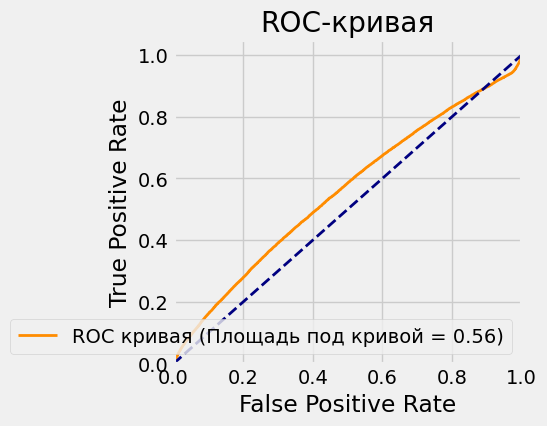

In [7]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = df.drop('flag', axis=1)
y = df['flag']

# Разделяем данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизируем данные (важно для градиентного спуска)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создаем и обучаем модель с использованием градиентного спуска
start_time = time.time()
sgd_classifier = SGDClassifier(max_iter=1000, alpha=0.001, random_state=42)
sgd_classifier.fit(X_train_scaled, y_train)
# Делаем предсказания на тестовом наборе
y_pred = sgd_classifier.predict(X_test_scaled)

# Оцениваем точность модели
roc_auc_sgd = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc_sgd}')

# Строим матрицу ошибок
conf_matrix_sgd = confusion_matrix(y_test, y_pred)
print('Матрица ошибок:')
print(conf_matrix_sgd)

end_time = time.time()
elapsed_time_sgd = end_time - start_time
print(f'Время на постройку модели: {elapsed_time_sgd:.2f} секунд')
# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, sgd_classifier.decision_function(X_test_scaled))
roc_auc_curve = auc(fpr, tpr)

# Выводим ROC-кривую
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (Площадь под кривой = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()


ROC AUC: 0.5029989019318641
Матрица ошибок:
[[576073   2610]
 [ 21093    224]]
Время на постройку модели: 782.07 секунд


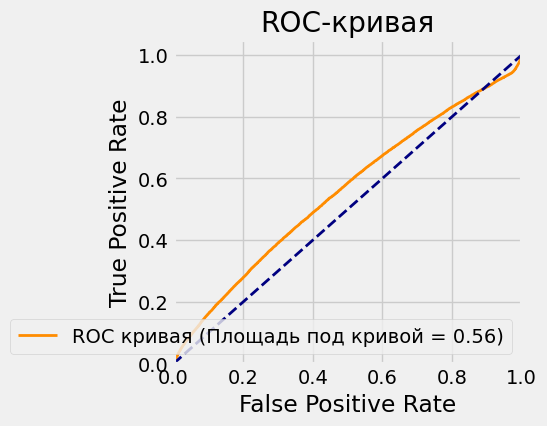

In [8]:
start_time = time.time()
knn_model = KNeighborsClassifier(n_neighbors=3)  # Выбираем количество соседей
knn_model.fit(X_train, y_train)

# Делаем предсказания на тестовом наборе данных
y_pred = knn_model.predict(X_test)

roc_auc_knn = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc_knn}')

# Строим матрицу ошибок
conf_matrix_knn = confusion_matrix(y_test, y_pred)
print('Матрица ошибок:')
print(conf_matrix_knn)

end_time = time.time()
elapsed_time_knn = end_time - start_time
print(f'Время на постройку модели: {elapsed_time_knn:.2f} секунд')
# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, sgd_classifier.decision_function(X_test_scaled))
roc_auc_curve = auc(fpr, tpr)

# Выводим ROC-кривую
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (Площадь под кривой = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

Лучшие параметры: {'var_smoothing': 1e-09}
ROC AUC: 0.522789423036686
Матрица ошибок:
[[557878  20805]
 [ 19579   1738]]
Время на постройку модели: 16.55 секунд


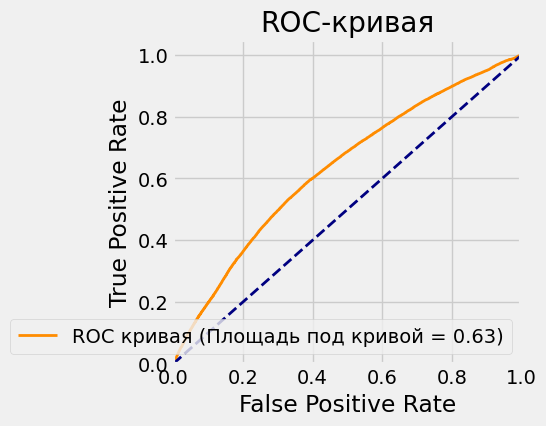

In [9]:
# Определение параметров для перебора
param_grid = {
    'var_smoothing': [1e-9, 1e-7, 1e-6, 1e-5]
}

# Создаем модель наивного байеса
nb_classifier = GaussianNB()

# Используем GridSearchCV для перебора гиперпараметров
start_time = time.time()
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры
best_params = grid_search.best_params_
print(f'Лучшие параметры: {best_params}')

# Делаем предсказания на тестовом наборе с лучшими параметрами
y_pred = grid_search.predict(X_test)

# Оцениваем точность модели
roc_auc_nb = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc_nb}')

# Строим матрицу ошибок
conf_matrix_nb = confusion_matrix(y_test, y_pred)
print('Матрица ошибок:')
print(conf_matrix_nb)

end_time = time.time()
elapsed_time_nb = end_time - start_time
print(f'Время на постройку модели: {elapsed_time_nb:.2f} секунд')
# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
roc_auc_curve = auc(fpr, tpr)

# Выводим ROC-кривую
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (Площадь под кривой = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

ROC AUC: 0.5077835992214992
Матрица ошибок:
[[573711   4972]
 [ 20802    515]]
Время на постройку модели: 263.93 секунд


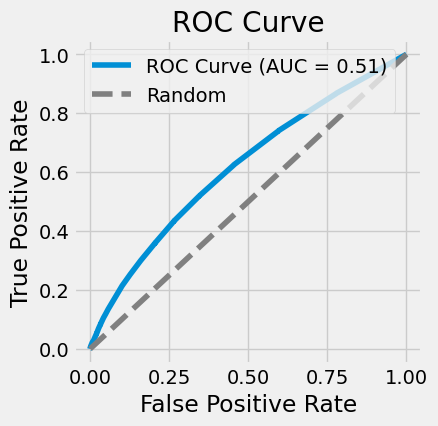

In [10]:
start_time = time.time()
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Получение предсказаний на тестовом наборе данных
y_pred = rf.predict(X_test)

# Вывод ROC AUC
roc_auc_rf_class = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc_rf_class}')

# Вывод матрицы ошибок
conf_matrix_rf_class = confusion_matrix(y_test, y_pred)
print(f'Матрица ошибок:\n{conf_matrix_rf_class}')

end_time = time.time()
elapsed_time_rf = end_time - start_time
print(f'Время на постройку модели: {elapsed_time_rf:.2f} секунд')
# Вывод ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_rf_class:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

ROC AUC: 0.5020350235076327
Матрица ошибок:
[[578025    658]
 [ 21206    111]]
Время на постройку модели: 281.03 секунд


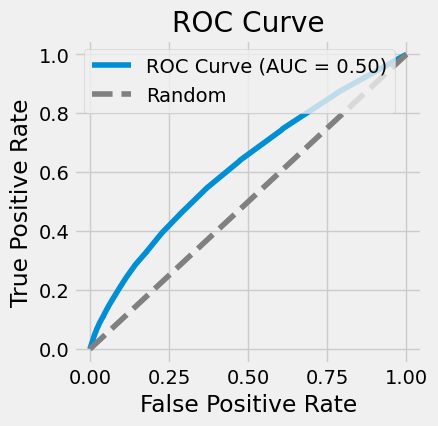

In [11]:
start_time = time.time()
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Получение предсказаний на тестовом наборе данных
y_pred = rf.predict(X_test)

# Вывод ROC AUC
roc_auc_rf = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc_rf}')

# Вывод матрицы ошибок
conf_matrix_rf = confusion_matrix(y_test, y_pred)
print(f'Матрица ошибок:\n{conf_matrix_rf}')

end_time = time.time()
elapsed_time_rf_class = end_time - start_time
print(f'Время на постройку модели: {elapsed_time_rf_class:.2f} секунд')

# Вывод ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [12]:
rus = RandomUnderSampler()

# Применение уменьшения выборки к данным
X_downscaled, y_downscaled = rus.fit_resample(X, y)
print(X_downscaled.shape)
print('________________________________')

print(y_downscaled.shape)
print('________________________________')

print(y_downscaled.value_counts())
print('________________________________')

(212884, 35)
________________________________
(212884,)
________________________________
flag
0    106442
1    106442
Name: count, dtype: int64
________________________________


ROC AUC: 0.6105779013475896
Матрица ошибок:
[[15396  5812]
 [10787 10582]]
Время на постройку модели: 0.39 секунд


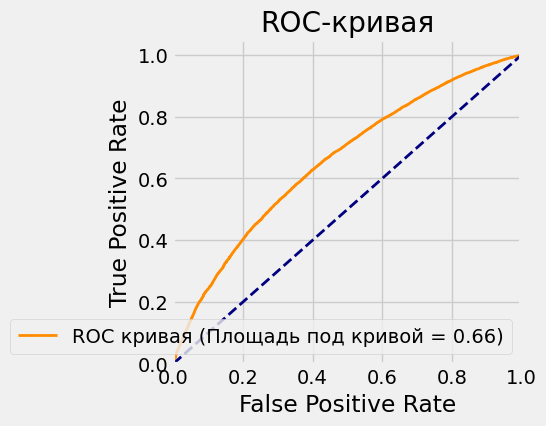

In [13]:
# Разделяем данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_downscaled, y_downscaled, test_size=0.2, random_state=42)

# Стандартизируем данные (важно для градиентного спуска)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создаем и обучаем модель с использованием градиентного спуска
start_time = time.time()
sgd_classifier = SGDClassifier(max_iter=1000, alpha=0.001, random_state=42)
sgd_classifier.fit(X_train_scaled, y_train)

# Делаем предсказания на тестовом наборе
y_pred = sgd_classifier.predict(X_test_scaled)

# Оцениваем точность модели
roc_auc_sgd_balanced = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc_sgd_balanced}')

# Строим матрицу ошибок
conf_matrix_sgd_balanced = confusion_matrix(y_test, y_pred)
print('Матрица ошибок:')
print(conf_matrix_sgd_balanced)

end_time = time.time()
elapsed_time_sgd_balanced = end_time - start_time
print(f'Время на постройку модели: {elapsed_time_sgd_balanced:.2f} секунд')
# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, sgd_classifier.decision_function(X_test_scaled))
roc_auc_curve = auc(fpr, tpr)

# Выводим ROC-кривую
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (Площадь под кривой = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

ROC AUC: 0.5564655986254637
Матрица ошибок:
[[12017  9191]
 [ 9695 11674]]
Время на постройку модели: 4.15 секунд


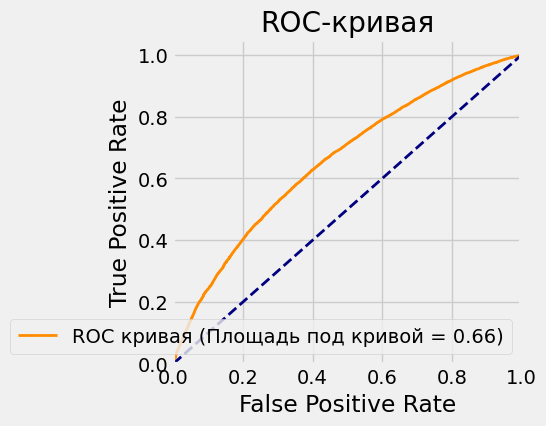

In [14]:
start_time = time.time()
knn_model_balanced = KNeighborsClassifier(n_neighbors=3)  # Выбираем количество соседей
knn_model_balanced.fit(X_train, y_train)

# Делаем предсказания на тестовом наборе данных
y_pred = knn_model_balanced.predict(X_test)

roc_auc_knn_balanced = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc_knn_balanced}')

# Строим матрицу ошибок
conf_matrix_knn_balanced = confusion_matrix(y_test, y_pred)
print('Матрица ошибок:')
print(conf_matrix_knn_balanced)

end_time = time.time()
elapsed_time_knn_balanced = end_time - start_time
print(f'Время на постройку модели: {elapsed_time_knn_balanced:.2f} секунд')
# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, knn_model_balanced.decision_function(X_test_scaled))
roc_auc_curve = auc(fpr, tpr)

# Выводим ROC-кривую
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (Площадь под кривой = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

Лучшие параметры: {'var_smoothing': 1e-05}
ROC AUC: 0.5458104274570846
Матрица ошибок:
[[19607  1601]
 [17798  3571]]
Время на постройку модели: 1.42 секунд


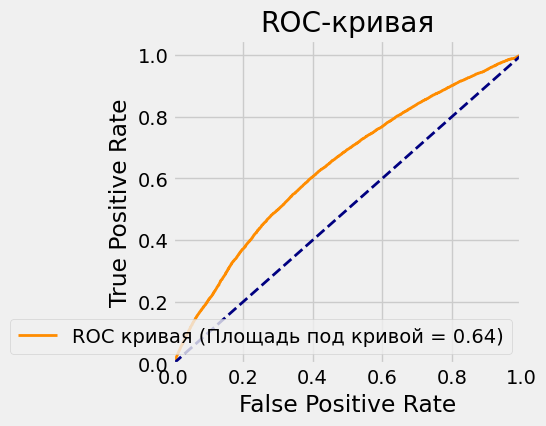

In [15]:
# Определение параметров для перебора
param_grid = {
    'var_smoothing': [1e-9, 1e-7, 1e-6, 1e-5]
}

# Создаем модель наивного байеса
nb_classifier = GaussianNB()

# Используем GridSearchCV для перебора гиперпараметров
start_time = time.time()
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры
best_params = grid_search.best_params_
print(f'Лучшие параметры: {best_params}')

# Делаем предсказания на тестовом наборе с лучшими параметрами
y_pred = grid_search.predict(X_test)

# Оцениваем точность модели
roc_auc_nb_balanced = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc_nb_balanced}')

# Строим матрицу ошибок
conf_matrix_nb_balanced = confusion_matrix(y_test, y_pred)
print('Матрица ошибок:')
print(conf_matrix_nb_balanced)

end_time = time.time()
elapsed_time_nb_balanced = end_time - start_time
print(f'Время на постройку модели: {elapsed_time_nb_balanced:.2f} секунд')
# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
roc_auc_curve = auc(fpr, tpr)

# Выводим ROC-кривую
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (Площадь под кривой = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()


ROC AUC: 0.6223243243212233
Матрица ошибок:
[[15135  6073]
 [10022 11347]]
Время на постройку модели: 1655.97 секунд


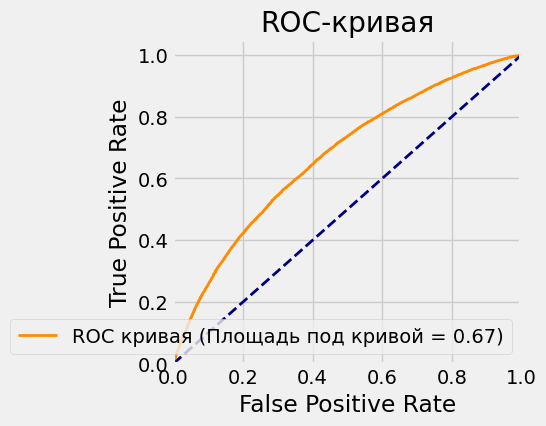

In [16]:
# Масштабируем данные с использованием MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучаем SVM
start_time = time.time()
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train_scaled, y_train)

# Делаем предсказания на тестовом наборе
y_pred = svm_classifier.predict(X_test_scaled)

# Вычисляем ROC AUC
roc_auc_svm_balanced = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc_svm_balanced}')

# Строим матрицу ошибок
conf_matrix_svm_balanced = confusion_matrix(y_test, y_pred)
print('Матрица ошибок:')
print(conf_matrix_svm_balanced)

end_time = time.time()
elapsed_time_svm_balanced = end_time - start_time
print(f'Время на постройку модели: {elapsed_time_svm_balanced:.2f} секунд')
# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, svm_classifier.decision_function(X_test_scaled))
roc_auc_curve = auc(fpr, tpr)

# Выводим ROC-кривую
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (Площадь под кривой = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

ROC AUC: 0.6133000891415643
Матрица ошибок:
[[13465  7743]
 [ 8725 12644]]
Время на постройку модели: 15.47 секунд


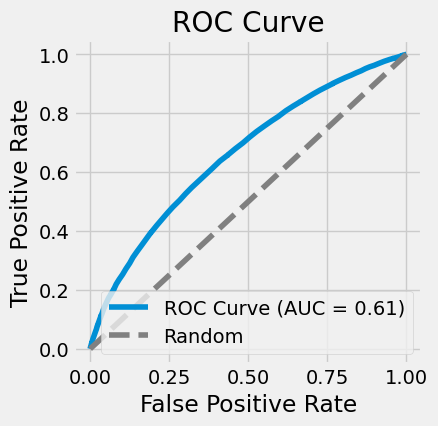

In [17]:
start_time = time.time()
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Получение предсказаний на тестовом наборе данных
y_pred = rf.predict(X_test)

# Вывод ROC AUC
roc_auc_rf_balanced = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc_rf_balanced}')

# Вывод матрицы ошибок
conf_matrix_rf_balanced = confusion_matrix(y_test, y_pred)
print(f'Матрица ошибок:\n{conf_matrix_rf_balanced}')

end_time = time.time()
elapsed_time_rf_balanced = end_time - start_time
print(f'Время на постройку модели: {elapsed_time_rf_balanced:.2f} секунд')
# Вывод ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_rf_balanced:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [23]:
print(f'Метрика для моделей без балансировки: '
      f'Градиентный спуск:{roc_auc_sgd}, Время на постройку: {elapsed_time_sgd}\n'
      f'Метод ближайших соседей:{roc_auc_knn}, Время на постройку: {elapsed_time_knn}\n'
      f'Случайный лес с внутренним балансом:{roc_auc_rf_class}, Время на постройку: {elapsed_time_rf_class}\n'
      f'Случайный лес:{roc_auc_rf}, Время на постройку: {elapsed_time_rf}\n'
      f'Наивный байес(Гауссовский):{roc_auc_nb}, Время на постройку: {elapsed_time_nb}\n')
print(f'Метрика для моделей после балансировки: '
      f'Градиентный спуск:{roc_auc_sgd_balanced}, Время на постройку: {elapsed_time_sgd_balanced}\n'
      f'Метод ближайших соседей:{roc_auc_knn_balanced}, Время на постройку: {elapsed_time_knn_balanced}\n'
      f'Метод опорных векторов:{roc_auc_svm_balanced}, Время на постройку: {elapsed_time_svm_balanced}\n'
      f'Случайный лес:{roc_auc_rf_balanced}, Время на постройку: {elapsed_time_rf_balanced}\n'
      f'Наивный байес(Гауссовский):{roc_auc_nb_balanced}, Время на постройку: {elapsed_time_nb_balanced}\n')

Метрика для моделей без балансировки: Градиентный спуск:0.5, Время на постройку: 3.032829761505127
Метод ближайших соседей:0.5029989019318641, Время на постройку: 782.0670881271362
Случайный лес с внутренним балансом:0.5077835992214992, Время на постройку: 281.02996301651
Случайный лес:0.5020350235076327, Время на постройку: 263.93146204948425
Наивный байес(Гауссовский):0.522789423036686, Время на постройку: 16.552237033843994

Метрика для моделей после балансировки: Градиентный спуск:0.6105779013475896, Время на постройку: 0.3850059509277344
Метод ближайших соседей:0.5564655986254637, Время на постройку: 4.147814035415649
Метод опорных векторов:0.6223243243212233, Время на постройку: 1655.9738721847534
Случайный лес:0.6133000891415643, Время на постройку: 15.471706867218018
Наивный байес(Гауссовский):0.5458104274570846, Время на постройку: 1.4177420139312744


In [26]:
print(f'Матрица ошибок для моделей без балансировки:\n '
      f'Градиентный спуск:\n{conf_matrix_sgd}\n'
      f'Метод ближайших соседей:\n{conf_matrix_knn}\n'
      f'Случайный лес с внутренним балансом:\n{conf_matrix_rf_class}\n'
      f'Случайный лес:\n{conf_matrix_rf}\n'
      f'Наивный байес(Гауссовский):\n{conf_matrix_nb}')
print(f'Матрица ошибок для моделей после балансировки:\n '
      f'Градиентный спуск:\n{conf_matrix_sgd_balanced}\n'
      f'Метод ближайших соседей:\n{conf_matrix_knn_balanced}\n'
      f'Метод опорных векторов:\n{conf_matrix_svm_balanced}\n'
      f'Случайный лес:\n{conf_matrix_rf_balanced}\n'
      f'Наивный байес(Гауссовский):\n{conf_matrix_nb_balanced}')

Матрица ошибок для моделей без балансировки:
 Градиентный спуск:
[[578683      0]
 [ 21317      0]]
Метод ближайших соседей:
[[576073   2610]
 [ 21093    224]]
Случайный лес с внутренним балансом:
[[573711   4972]
 [ 20802    515]]
Случайный лес:
[[578025    658]
 [ 21206    111]]
Наивный байес(Гауссовский):
[[557878  20805]
 [ 19579   1738]]
Матрица ошибок для моделей после балансировки:
 Градиентный спуск:
[[15396  5812]
 [10787 10582]]
Метод ближайших соседей:
[[12017  9191]
 [ 9695 11674]]
Метод опорных векторов:
[[15135  6073]
 [10022 11347]]
Случайный лес:
[[13465  7743]
 [ 8725 12644]]
Наивный байес(Гауссовский):
[[19607  1601]
 [17798  3571]]


Как я и сказал в первом ноутбуке: случайный лес лучше всего для построения бейслайна. Он видит правильные положительные ответы и без балансировки, но с внутренней балансировкой, к сожалению, ситуация не сильно лучше. После балансировки он вполне неплохо идентифицирует TP TN. К нему можно отнести метод ближайших соседей и метод опорных векторов. Эти модели тоже неплохо показывают себя на этих данных. Однако, как мы видим из времени построения, ближайшие соседи очень долго выстраивают модель, что неэффективно скажется на дальнейшем анализе. Метод опорных векторов показал самое большое время на построение модели. Поэтому будем использовать для основного анализа случайный лес, после нахождения лучшей модели, попробуем еще раз провести тесты на ближайших соседях и опорных векторах. 